# Exploratory Data Analysis of Stimulus Triggered Averages
*Ian Malone*

### Load data and check structure

In [32]:
import pandas as pd

df_sta = pd.read_csv('C:\\Users\\Ian\\Google Drive\\IanGMalone\\UF\\Lab\\DataAndFigures\\Analysis\\df_STA_2020_11_25.csv')
df_sta.head()

,Animal,Day,Side,Stim_Amplitude,Sample,STA_Amplitude
0,S01,D04,Left,100.0,0,0.065894
1,S01,D04,Left,100.0,1,0.109876
2,S01,D04,Left,100.0,2,0.131164
3,S01,D04,Left,100.0,3,0.101857
4,S01,D04,Left,100.0,4,0.125714


In [33]:
df_sta.dtypes

Animal             object
Day                object
Side               object
Stim_Amplitude    float64
Sample              int64
STA_Amplitude     float64
dtype: object

#### For this analysis, we will only keep the left side EMG

In [34]:
df_sta = df_sta[df_sta["Side"] == 'Right']

In [35]:
print(df_sta.Animal.unique())
print(df_sta.Day.unique())
print(df_sta.Side.unique())
print(df_sta.Stim_Amplitude.unique())

['S01' 'S02' 'S03']
['D04' 'D06' 'D08']
['Right']
[100. 110. 120. 130. 140. 150. 160. 170. 180. 190. 200. 210. 220. 230.
 240. 250. 260. 270. 280. 290. 300. 310. 320. 330. 340. 350. 360. 370.
 380. 390. 400. 410. 420. 430. 440. 450. 460. 470. 480. 490. 500. 510.
 520. 530. 540. 550. 560. 570. 580. 590. 600.]


### 1) Waveform from stimulus triggered average for each current amplitude, each animal, each day

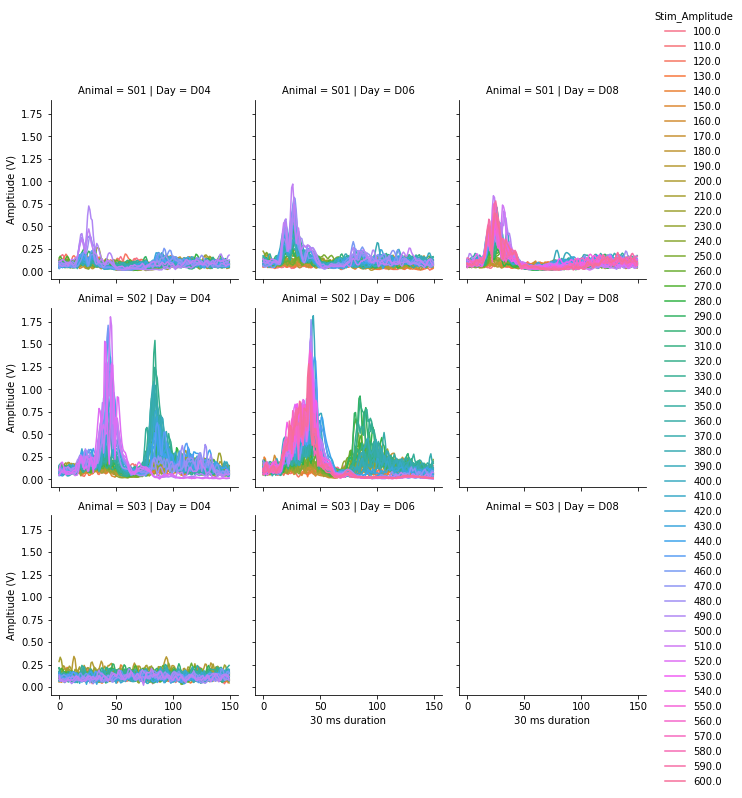

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(df_sta, col='Day', row='Animal', hue='Stim_Amplitude')
g.map_dataframe(sns.lineplot, x='Sample', y='STA_Amplitude')
g.set_axis_labels('30 ms duration', 'Ampltiude (V)')
g.add_legend()

#### Observations
- Each animal will need to have MEPs viewed on a unique y-axis. While this will help in viewing the data, during analysis, animals with large scale EMG values will still dominate and potentially obscure interesting group trends in MEP shape, latency, and longitudinal change.
- Another approach is to normalize all MEP values between 0 and 1. This must be done for each individual animal and all days must be included in the normalization to preserve day-to-day changes. However, this normalization prevents direct comparisons between animals. Use this if you only care about the change over time for animals and not the absolute comparison of EMG values betweeen animals. This may be a valid approach due to variability in electrodes, implantation, etc. preventing meaningful comparison of MEP magnitude between animals.

### 2) Area under the stimulus triggered average curve for each current amplitude, each animal, and each day

We will need to integrate the stimulus triggered average curves to find the area beneath them. We can then compare these areas uner the curve (AUCs) between groups, days, stimulus intensities, etc.

The trapezoidal rule provides a simple way to integrate a function but typically has much larger error than Simpson's rule without saving significant compute time. We will use Simpson's rule.

In [36]:
df_sta.head()

,Animal,Day,Side,Stim_Amplitude,Sample,STA_Amplitude
6150,S01,D04,Right,100.0,0,0.119449
6151,S01,D04,Right,100.0,1,0.156867
6152,S01,D04,Right,100.0,2,0.173611
6153,S01,D04,Right,100.0,3,0.184769
6154,S01,D04,Right,100.0,4,0.171930


We now want to add a column that defines sample bins of interest.

_NOTE: Sample should be 

In [93]:
from scipy import integrate

# df_statest = df_sta.copy()
# df_statest = df_statest.drop('Sample', 1)
# df_statest.head()

df_statest.groupby(['Animal', 'Day', 'Side', 'Stim_Amplitude'])['STA_Amplitude'].apply(integrate.simps).reset_index()

,Animal,Day,Side,Stim_Amplitude,STA_Amplitude
0,S01,D04,Right,100.0,14.806097
1,S01,D04,Right,110.0,11.761126
2,S01,D04,Right,120.0,15.555454
3,S01,D04,Right,130.0,10.486245
4,S01,D04,Right,140.0,11.449513
...,...,...,...,...,...
263,S03,D04,Right,460.0,18.202061
264,S03,D04,Right,470.0,15.427415
265,S03,D04,Right,480.0,15.352367
266,S03,D04,Right,490.0,16.801275


### 3) Peak to peak from stimulus triggered average for each current amplitude, each animal, each day

### 4) Latency from stimulus pulse to stimulus triggered average for each current amplitude, each animal, each day

### 5) Time domains of stimulus triggered average

### 6) Differences in any of these parameters based on time of day?

### 7) How are we going to present the impedance data in the Neilsen paper? I’m still not clear on this.

### 8) Additional things we can look at (e.g., wavelet, FFT, HMM, etc.)
Look in manuscript file for notes on ideas. Also look in Daily Notes on OneNote for papers that did EMG analysis well.